# Building car price prediction model for CarDekho website
# Part 2: Train data preparation and model building
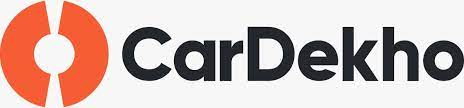
## About project
[CarDekho](https://www.cardekho.com/) is India's leading car search venture that helps users buy cars. Its website and app carry rich automotive content such as expert reviews, detailed specs and prices, comparisons as well as videos and pictures of all car brands and models available in India. The company has tie-ups with many auto manufacturers, more than 4000 car dealers and numerous financial institutions to facilitate the purchase of vehicles.

In this project, we'll collect data about used cars from CarDekho website and use it to build car price prediction model. This model may later be used by CarDekho for suggesting the price of posted by user used car.

The project is divided into 2 notebooks:
* [Part 1: Data collection and splitting into train and validation datasets](https://nbviewer.org/github/ZaikaBohdan/ds_car_price_proj/blob/main/car_price_part_1.ipynb)
* Part 2: Train data preparation and model building (current)

**The goal of the current notebook** is to build car price prediction model based on train dataset and evaluate its success on validation dataset. We will achive it by following next steps:
1. Clean train dataset.
2. Do exploratory data analysis, feature engineering and feature selection on train data.
3. Train regression models on train dataset.
4. Choose the best one and test it on validation dataset.

# Importing necessary libraries for project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_columns = None

# Importing datasets

In [2]:
raw_train, raw_valid = pd.read_csv('data/train.csv'), pd.read_csv('data/valid.csv')

# fixing data type of seats column
raw_train = raw_train.astype({'seats':str})
raw_train['seats'] = raw_train['seats'].str.replace('.0','', regex=False).replace({'nan':np.nan})
clean_train = raw_train.copy()

raw_valid = raw_valid.astype({'seats':str})
raw_valid['seats'] = raw_valid['seats'].str.replace('.0','', regex=False).replace({'nan':np.nan})

clean_train.head()

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp
0,Maruti Wagon R VXI Plus,2018.0,480000.0,4500.0,Petrol,Dealer,Manual,First Owner,5,998.0,67.04
1,Ford Figo Diesel Titanium,2012.0,320000.0,103994.0,Diesel,Individual,Manual,Fourth & Above Owner,5,1399.0,68.00
2,Hyundai Creta 1.4 CRDi S,2018.0,865000.0,73249.0,Diesel,Dealer,Manual,First Owner,5,1396.0,88.70
3,Maruti Wagon R VXI Optional,2017.0,400000.0,70000.0,Petrol,Individual,Manual,First Owner,5,998.0,67.04
4,Datsun RediGO T Option,2016.0,330000.0,11995.0,Petrol,Dealer,Manual,First Owner,5,799.0,53.64


In [3]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24046 entries, 0 to 24045
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               24046 non-null  object 
 1   year               24046 non-null  float64
 2   selling_price_inr  24046 non-null  float64
 3   km_driven          24045 non-null  float64
 4   fuel               24046 non-null  object 
 5   seller_type        24046 non-null  object 
 6   transmission       24046 non-null  object 
 7   owner              24046 non-null  object 
 8   seats              23902 non-null  object 
 9   engine_cc          23881 non-null  float64
 10  max_power_bhp      23710 non-null  float64
dtypes: float64(5), object(6)
memory usage: 2.0+ MB


In [4]:
raw_valid.head()

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp
0,Honda City 1.5 S MT,2017.0,675000.0,49523.0,Petrol,Dealer,Manual,First Owner,5,1497.0,118.00
1,Renault Duster 110PS Diesel RxZ,2015.0,625000.0,159000.0,Diesel,Individual,Manual,First Owner,5,1461.0,108.45
2,Maruti Swift VDI BSIV,2014.0,385000.0,30167.0,Diesel,Dealer,Manual,First Owner,5,1248.0,74.00
3,Skoda Fabia 1.2L Diesel Elegance,2011.0,300000.0,265000.0,Diesel,Individual,Manual,Second Owner,5,1199.0,75.00
4,Maruti Ertiga ZDI,2013.0,640000.0,39000.0,Diesel,Individual,Manual,First Owner,7,1248.0,88.80


# Data cleaning of train dataset

Let's start by taking a look at amount of fields with null values.

In [5]:
def null_counter(df):
    display(
        pd.DataFrame(
            df.isnull().sum(axis=1).value_counts().sort_index(ascending=False)
        ).reset_index().rename(columns={'index':'n_nulls', 0:'n_rows'})
    )
    
def n_nulls_cols_counter(df, n_nulls):
    print(
        df[df.isnull().sum(axis=1)==n_nulls].apply(lambda row: frozenset(df.columns[row.isnull()]), axis=1).value_counts()
    )

def all_null_cols_counter(df):
    uniq_n_nulls = sorted(df.isnull().sum(axis=1).unique(), reverse = True)[:-1]
    for n in uniq_n_nulls:
        print('>>> List of columns with null values, where amount of nulls =', n,'<<<')
        n_nulls_cols_counter(df, n)
        print()

In [6]:
null_counter(clean_train)

,n_nulls,n_rows
0,3,115
1,2,57
2,1,187
3,0,23687


In [7]:
all_null_cols_counter(clean_train)

>>> List of columns with null values, where amount of nulls = 3 <<<
(max_power_bhp, engine_cc, seats)    115
dtype: int64

>>> List of columns with null values, where amount of nulls = 2 <<<
(max_power_bhp, engine_cc)    40
(max_power_bhp, seats)        17
dtype: int64

>>> List of columns with null values, where amount of nulls = 1 <<<
(max_power_bhp)    164
(seats)             12
(engine_cc)         10
(km_driven)          1
dtype: int64



First let's deal with null value in *km_driven*, which previously contained an outlier in Part 1 of the project. We will fill it with mean *km_driven* of cars with 'Fourth & Above Owner', since it was the reason why we droped this value.

In [8]:
clean_train.loc[clean_train['km_driven'].isnull(), 'km_driven'] = clean_train.loc[clean_train['owner']=='Fourth & Above Owner', 'km_driven'].mean()
all_null_cols_counter(clean_train)

>>> List of columns with null values, where amount of nulls = 3 <<<
(max_power_bhp, engine_cc, seats)    115
dtype: int64

>>> List of columns with null values, where amount of nulls = 2 <<<
(max_power_bhp, engine_cc)    40
(max_power_bhp, seats)        17
dtype: int64

>>> List of columns with null values, where amount of nulls = 1 <<<
(max_power_bhp)    164
(seats)             12
(engine_cc)         10
dtype: int64



Now let's get brand of car from *name* column and impute the remaining null values with mean (*max_power_bhp, engine_cc*) and mode (*seats*) of the corresponding brand cars in the code cells below.

In [9]:
clean_train['brand'] = clean_train['name'].str.split().str[0]
clean_train['brand'].unique()

array(['Maruti', 'Ford', 'Hyundai', 'Datsun', 'Volkswagen', 'Honda',
       'Tata', 'Toyota', 'Chevrolet', 'Mahindra', 'Renault',
       'Mercedes-Benz', 'Skoda', 'Fiat', 'Nissan', 'BMW', 'Land', 'Audi',
       'Porsche', 'Volvo', 'Isuzu', 'Mitsubishi', 'Jaguar', 'Jeep', 'Kia',
       'Bentley', 'MG', 'Mercedes-AMG', 'Mini', 'Ambassador', 'Lexus',
       'Force', 'ISUZU', 'Daewoo', 'OpelCorsa', 'Maserati', 'Premier',
       'Rolls-Royce', 'Lamborghini', 'DC', 'Peugeot', 'Ferrari', 'Opel',
       'Ashok'], dtype=object)

Next values in new column *brand* should be changed:
* Land -> Land Rover
* Mini -> Mini Cooper
* OpelCorsa -> Opel
* Isuzu -> ISUZU
* Ashok -> Ashok Leyland
* Mercedes-AMG -> Mercedes-Benz

In [10]:
replace_dict = {
    'Land' : 'Land Rover', 
    'Mini' : 'Mini Cooper',
    'OpelCorsa' : 'Opel',
    'Isuzu' : 'ISUZU',
    'Ashok' : 'Ashok Leyland',
    'Mercedes-AMG' : 'Mercedes-Benz'
}
clean_train['brand'] = clean_train['brand'].replace(replace_dict)
clean_train['brand'].unique()

array(['Maruti', 'Ford', 'Hyundai', 'Datsun', 'Volkswagen', 'Honda',
       'Tata', 'Toyota', 'Chevrolet', 'Mahindra', 'Renault',
       'Mercedes-Benz', 'Skoda', 'Fiat', 'Nissan', 'BMW', 'Land Rover',
       'Audi', 'Porsche', 'Volvo', 'ISUZU', 'Mitsubishi', 'Jaguar',
       'Jeep', 'Kia', 'Bentley', 'MG', 'Mini Cooper', 'Ambassador',
       'Lexus', 'Force', 'Daewoo', 'Opel', 'Maserati', 'Premier',
       'Rolls-Royce', 'Lamborghini', 'DC', 'Peugeot', 'Ferrari',
       'Ashok Leyland'], dtype=object)

In [11]:
def fillna_stat_by_col(data, col, fill_method):
    df = data.copy()
    unique_vals = df.loc[df.isnull().any(axis=1), col].unique()
    for val in unique_vals:
        if fill_method=='mean':
            df[df[col]==val] = df[df[col]==val].fillna(df[df[col]==val].mean(numeric_only=True))
        elif fill_method=='mode':
            df[df[col]==val] = df[df[col]==val].fillna(df[df[col]==val].mode().iloc[0,:])
        else:
            print(f"Error: method '{fill_method}' is incorrect")
            return
    
    return df

In [12]:
print('>>> Before filling null values')
null_counter(clean_train)
clean_train.loc[:, clean_train.columns != 'seats'] = fillna_stat_by_col(
    clean_train.loc[:, clean_train.columns != 'seats'],
    'brand',
    'mean'
)
print('\n>>> After filling null values in engine_cc and max_power_bhp')
null_counter(clean_train)
clean_train = fillna_stat_by_col(
    clean_train,
    'brand',
    'mode'
)
print('\n>>> After filling null values in seats')
null_counter(clean_train)

>>> Before filling null values


,n_nulls,n_rows
0,3,115
1,2,57
2,1,186
3,0,23688



>>> After filling null values in engine_cc and max_power_bhp


,n_nulls,n_rows
0,3,1
1,1,143
2,0,23902



>>> After filling null values in seats


,n_nulls,n_rows
0,3,1
1,0,24045


Let's take a look at last row with null values.

In [13]:
clean_train.loc[clean_train.isnull().any(axis=1), :]

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,brand
18466,Peugeot 309 GLD,1997.0,57000.0,110000.0,Diesel,Individual,Manual,Third Owner,NaN,NaN,NaN,Peugeot


We will fill these null values with information from [ultimatespecs.com](https://www.ultimatespecs.com/car-specs/Peugeot/1974/Peugeot-309-GLD---GRD.html).

In [14]:
clean_train.loc[clean_train.isnull().any(axis=1), ['seats', 'engine_cc', 'max_power_bhp']] = ['5', 1905, 64]
null_counter(clean_train)

,n_nulls,n_rows
0,0,24046


We don't have null values left. Let's drop *name* column, since we won't need it anymore, and  move to exploratory data analysis.

In [15]:
fe_train = clean_train.drop(columns='name')
fe_train.columns

Index(['year', 'selling_price_inr', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'seats', 'engine_cc', 'max_power_bhp',
       'brand'],
      dtype='object')

# Exploratory data analysis
In this section we will explore data and find patterns, which may be useful for feature engineering later. Since the goal of the project is to  build car price prediction model, the main purpose of this chapter is to find relations between features and target column (*selling_price_inr*).

## *year* and *transmission* features
Let's start by plotting scatter plot of *year* and *selling_price_inr* with *transmission* marked by color.

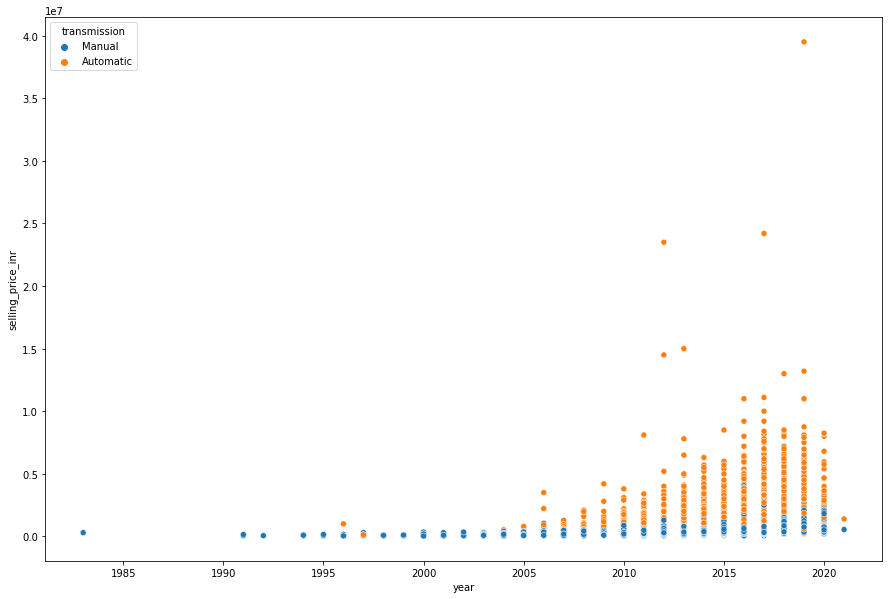

In [16]:
fig, scatter = plt.subplots(figsize = (15,10))
scatter = sns.scatterplot(data=fe_train, x="year", y="selling_price_inr", hue="transmission")

In general, the mean and deviation of car prices increase with each year and cars with automatic transmission tend to be more expensive.
## *km_driven* and *seller_type* features
The visualization below shows relation between *km_driven, seller_type* and *selling_price_inr* columns.

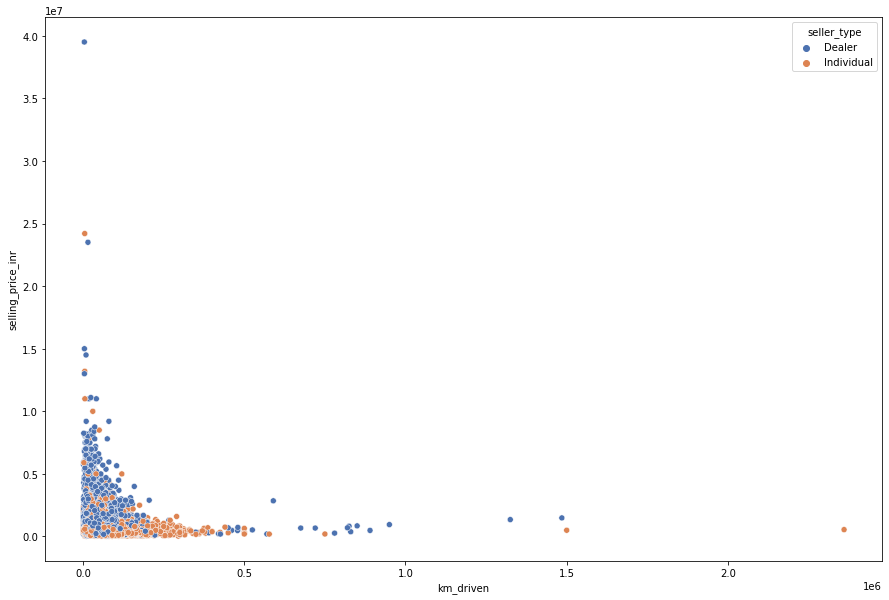

In [17]:
fig, scatter = plt.subplots(figsize = (15,10))
scatter = sns.scatterplot(data=fe_train, x="km_driven", y="selling_price_inr",hue="seller_type", palette="deep")

As can be seen, selling price tend to go down with the rise of *km_driven*. Also cars with 200000-400000 km driven are usually sold by individuals, but any clear pattern between *seller_type* and *selling_price_inr* columns is not observed.

## *engine_cc* and *max_power_bhp* features
The scatter plots below represent dependency between *engine_cc, max_power_bhp* and *selling_price_inr*.

In [18]:
def plot_col_signif(df, feat_cols, targ_col, n_rows=1, n_cols=1):
    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(6*n_cols,4*n_rows), squeeze=False, constrained_layout = True)

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                feat_col = feat_cols[i*n_cols+j]
            except:
                plt.show()
                return
            
            pears_corr = df.corr()[feat_col][targ_col]
            spear_corr = df.corr(method='spearman')[feat_col][targ_col]

            axes[i,j].scatter(df[feat_col], df[targ_col])
            axes[i,j].set_xlabel('feature')
            axes[i,j].set_ylabel('target')
            axes[i,j].set_title(f'Feature: {feat_col}\nPearson\'s r = {pears_corr:.2f}\n Spearman\'s ρ = {spear_corr:.2f}')
            
    plt.show()

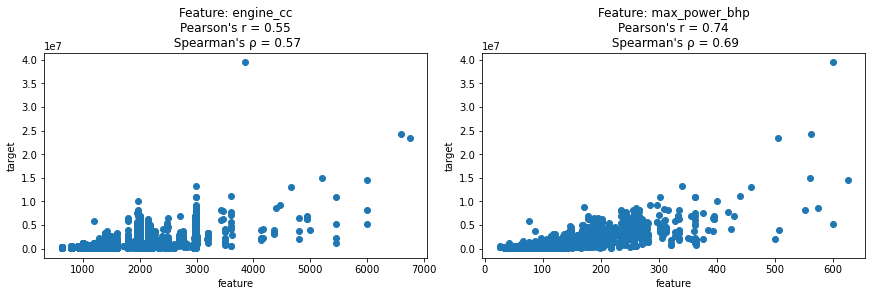

In [19]:
plot_col_signif(fe_train, ['engine_cc', 'max_power_bhp'], 'selling_price_inr', 1, 2)

As it is observed, both features have moderate-high correlation with selling price.

## *brand* feature
We'll visualize mean selling price grouped by *brand* values below.

In [20]:
def mean_per_col_barh(df, col):
    mean_price_per_col = df.groupby([col]).mean()['selling_price_inr'].sort_values(ascending=False)

    fig, barplot = plt.subplots(figsize = (15,10))
    barplot = sns.barplot(x=mean_price_per_col.values, y=mean_price_per_col.index, orient='h', palette="viridis")
    barplot.bar_label(barplot.containers[0])
    barplot.spines['top'].set_visible(False)
    barplot.spines['right'].set_visible(False)
    barplot.spines['bottom'].set_visible(False)
    barplot.get_xaxis().set_ticks([])
    barplot.set_title(f'Mean car price for each {col}')
    barplot.set_ylabel('')
    plt.show()

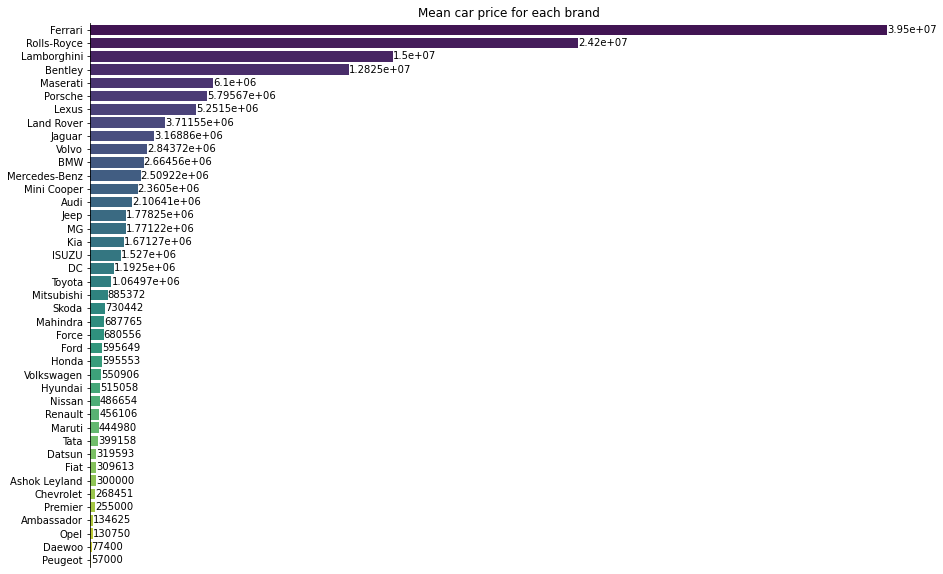

In [21]:
mean_per_col_barh(fe_train, 'brand')

Obviously, brand inluences the price and chart above confirms that it is true for our data.
## *seats, fuel, owner*  features
The boxplots below show distribituion of selling price values grouped by *seats, fuel* and *owner*.

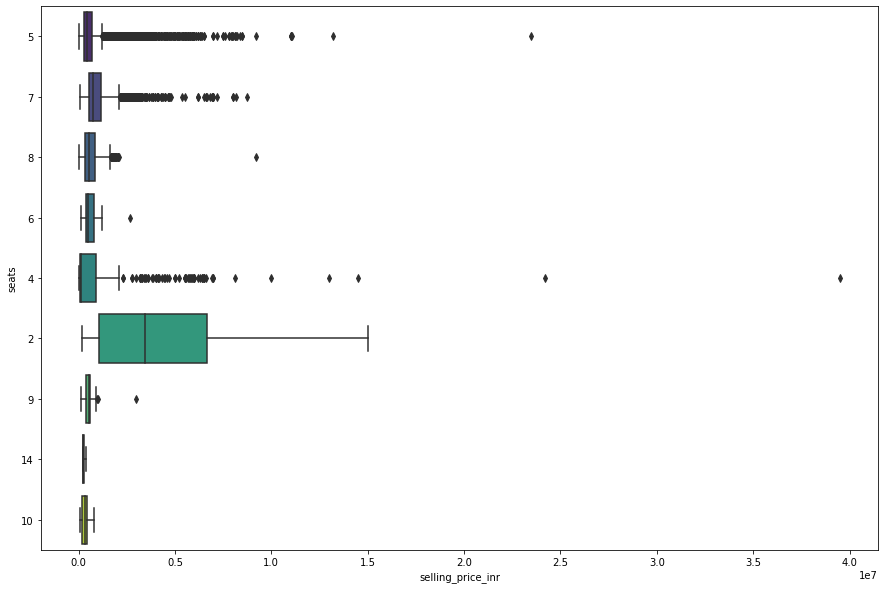

In [22]:
fig, boxplot = plt.subplots(figsize = (15,10))
boxplot = sns.boxplot(
    data=fe_train,
    x='selling_price_inr', 
    y='seats',
    orient='h',
    palette="viridis"
)

It can be clearly seen that selling price values of cars with 2, 4, 5 and 7 seats have big deviation, while other have price < 2,500,000 for most cases. 

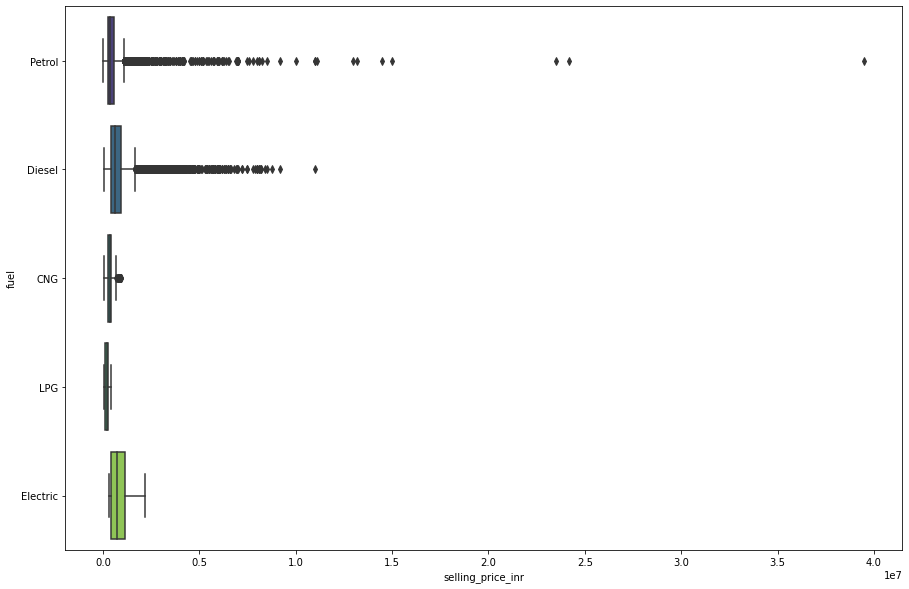

In [23]:
fig, boxplot = plt.subplots(figsize = (15,10))
boxplot = sns.boxplot(
    data=fe_train,
    x='selling_price_inr', 
    y='fuel',
    orient='h',
    palette="viridis"
)

The graph above reveals that selling prices of cars with petrol and diesel fuel also have big deviation, while other have price < 2,000,000. 

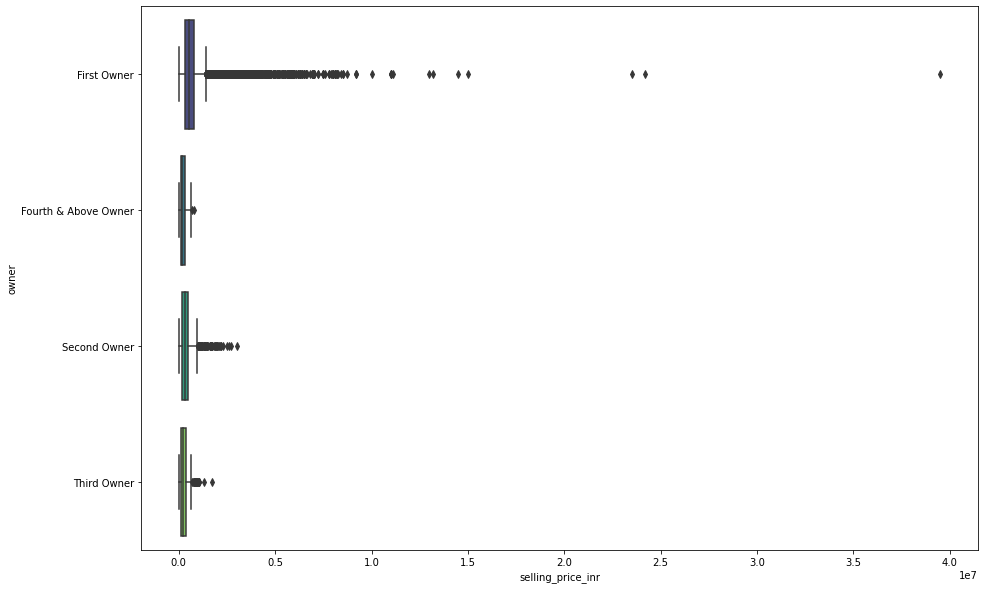

In [24]:
fig, boxplot = plt.subplots(figsize = (15,10))
boxplot = sns.boxplot(
    data=fe_train,
    x='selling_price_inr', 
    y='owner',
    orient='h',
    palette="viridis"
)

As was expected, the price of car tends to decrease with each owner. Also, there is a huge difference in deviation of selling price between first and second owner.

## Conclusion
As a result of exploratory data analysis, we find out that:
* selling price mean and deviation have positive correlation with **year** column;
* cars with automatic **transmission** tend to be more expensive;
* car price mean and deviation tend to go down with the rise of **km_driven** column;
* any clear pattern between **seller_type** and *selling_price_inr* columns is not observed;
* **engine_cc** has moderate correlation with selling price;
* **max_power_bhp** has high correlation with car price;
* prices of cars with 2, 4, 5 and 7 **seats** have big deviation, while other have price < 2,500,000 for most cases;
* selling prices of cars with petrol and diesel **fuel** also have big deviation, while other have price < 2,000,000;
* the price of car tends to decrease with each **owner** and there is a huge difference in deviation of selling price between first and second owner.

# Feature Engineering
Let's use knowledge we gained during exploratory analysis to create new features.

In [25]:
fe_train.head()

,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,brand
0,2018.0,480000.0,4500.0,Petrol,Dealer,Manual,First Owner,5,998.0,67.04,Maruti
1,2012.0,320000.0,103994.0,Diesel,Individual,Manual,Fourth & Above Owner,5,1399.0,68.00,Ford
2,2018.0,865000.0,73249.0,Diesel,Dealer,Manual,First Owner,5,1396.0,88.70,Hyundai
3,2017.0,400000.0,70000.0,Petrol,Individual,Manual,First Owner,5,998.0,67.04,Maruti
4,2016.0,330000.0,11995.0,Petrol,Dealer,Manual,First Owner,5,799.0,53.64,Datsun


*fuel, seats, owner* values have similar patterns with selling price, so we will analogically create new *..._flg* fields:
* *fuel_flg* = 1 if fuel is diesel or petrol and 0 in other cases;
* *seats_flg* = 1 if car has 2, 4, 5 or 7 seats and 0 in other cases;
* *owner_flg* = 1 if car onwer is first and 0 in other cases.

*seller_type* and *transmission* have only 2 unique values, so we will create new *..._flg* fields by replacing them with 0 and 1.

In [26]:
def col_to_col_flg(data, col, vals_1):
    df = data.copy()
    df[col+'_flg'] = df.apply(lambda row: int(row[col] in vals_1), axis=1)
    print(f'>>> Check correctness of {col}_flg <<<\n')
    print(df[col+'_flg'].value_counts(), '\n')
    print(df[col].value_counts(), '\n')
    return df

In [27]:
cols_vals_1_dict = {
    'fuel': ['Diesel', 'Petrol'],
    'seats': ['2', '4', '5', '7'],
    'owner': ['First Owner'],
    'seller_type': ['Individual'],
    'transmission': ['Manual']
}

for col, vals_1 in cols_vals_1_dict.items():
    fe_train = col_to_col_flg(fe_train, col, vals_1)

>>> Check correctness of fuel_flg <<<

1    23610
0      436
Name: fuel_flg, dtype: int64 

Diesel      12102
Petrol      11508
CNG           334
LPG            92
Electric       10
Name: fuel, dtype: int64 

>>> Check correctness of seats_flg <<<

1    23090
0      956
Name: seats_flg, dtype: int64 

5     19742
7      3010
8       606
4       316
6       179
9       126
10       42
2        22
14        3
Name: seats, dtype: int64 

>>> Check correctness of owner_flg <<<

1    21645
0     2401
Name: owner_flg, dtype: int64 

First Owner             21645
Second Owner             1769
Third Owner               474
Fourth & Above Owner      158
Name: owner, dtype: int64 

>>> Check correctness of seller_type_flg <<<

1    12515
0    11531
Name: seller_type_flg, dtype: int64 

Individual    12515
Dealer        11531
Name: seller_type, dtype: int64 

>>> Check correctness of transmission_flg <<<

1    20006
0     4040
Name: transmission_flg, dtype: int64 

Manual       20006
Automatic   

*brand* column have a valuable information for our model, but contains a lot of unique values and some models take as input only numeric fields, so using it without any data encoding may not be the best approach. We will create next new fields based on this column and test their usefulness for future model later:
* brand_top_half = 1 if brand is in the top half means of selling price grouped by brand and 0 in other cases;
* brand_top_third = 1 if brand is in the top third means of selling price grouped by brand and 0 in other cases;
* brand_bottom_third = 1 if brand is in the bottom third means of selling price grouped by brand and 0 in other cases.

In [28]:
mean_price_per_brand = fe_train.groupby(['brand']).mean()['selling_price_inr'].sort_values(ascending=False)
n = len(mean_price_per_brand)

fe_train['brand_top_half'] = fe_train.apply(lambda row: int(row['brand'] in mean_price_per_brand.iloc[:n//2].index), axis=1)
fe_train['brand_top_third'] = fe_train.apply(lambda row: int(row['brand'] in mean_price_per_brand.iloc[:n//3].index), axis=1)
fe_train['brand_bottom_third'] = fe_train.apply(lambda row: int(row['brand'] in mean_price_per_brand.iloc[-n//3:].index), axis=1)

fe_train.head()

,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,brand,fuel_flg,seats_flg,owner_flg,seller_type_flg,transmission_flg,brand_top_half,brand_top_third,brand_bottom_third
0,2018.0,480000.0,4500.0,Petrol,Dealer,Manual,First Owner,5,998.0,67.04,Maruti,1,1,1,0,1,0,0,1
1,2012.0,320000.0,103994.0,Diesel,Individual,Manual,Fourth & Above Owner,5,1399.0,68.00,Ford,1,1,0,1,1,0,0,0
2,2018.0,865000.0,73249.0,Diesel,Dealer,Manual,First Owner,5,1396.0,88.70,Hyundai,1,1,1,0,1,0,0,1
3,2017.0,400000.0,70000.0,Petrol,Individual,Manual,First Owner,5,998.0,67.04,Maruti,1,1,1,1,1,0,0,1
4,2016.0,330000.0,11995.0,Petrol,Dealer,Manual,First Owner,5,799.0,53.64,Datsun,1,1,1,0,1,0,0,1


As a last step of this section, let's drop categorical columns and split train dataset into features (X) and target (y).

In [29]:
def fe_split(fe_df):
    return fe_df.select_dtypes(include='number').drop(columns='selling_price_inr'), fe_df['selling_price_inr']

X_train, y_train = fe_split(fe_train)
X_train.head()

,year,km_driven,engine_cc,max_power_bhp,fuel_flg,seats_flg,owner_flg,seller_type_flg,transmission_flg,brand_top_half,brand_top_third,brand_bottom_third
0,2018.0,4500.0,998.0,67.04,1,1,1,0,1,0,0,1
1,2012.0,103994.0,1399.0,68.00,1,1,0,1,1,0,0,0
2,2018.0,73249.0,1396.0,88.70,1,1,1,0,1,0,0,1
3,2017.0,70000.0,998.0,67.04,1,1,1,1,1,0,0,1
4,2016.0,11995.0,799.0,53.64,1,1,1,0,1,0,0,1


In [30]:
y_train.head()

0    480000.0
1    320000.0
2    865000.0
3    400000.0
4    330000.0
Name: selling_price_inr, dtype: float64

# Model Building
We will use Random Forest Regressor as model for predicting car prices. Grid search method will help us to find best hyper parameters for our model and then we will test it on validation dataset.

## Grid Search
To find the best hyper parameters of the model we will use adjusted R-squared as the main score.

In [31]:
# creating adjusted R-squared score, since it isn't present in sklearn library
# estimator required for dynamic change of p value through cross-val process
def adj_r2(estimator, X, y_true):
    n, p = X.shape
    y_pred = estimator.predict(X)
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2)*(n - 1)/(n - p -1)

param_dict = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 5, 7, 9],
    'random_state': [0]
}
scoring_dict = {
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
    "adj_R2": adj_r2
}

def gscv(X_train, y_train):
    grid = GridSearchCV(
        RandomForestRegressor(),
        param_grid=param_dict,
        scoring=scoring_dict,
        refit="adj_R2"
    ) 
    grid.fit(X_train, y_train)
    
    return grid

grid = gscv(X_train, y_train)

In [32]:
# checking scores of best model
def check_results(grid):
    results_df = pd.DataFrame(grid.cv_results_)
    cols = [f'{el1}_test_{el2}' for el1 in ['mean', 'std', 'rank'] for el2 in ['MAE', 'MSE', 'adj_R2']]
    return results_df.loc[results_df['params']==grid.best_params_, cols].abs().T

In [33]:
check_results(grid)

,5
mean_test_MAE,1.037318e+05
mean_test_MSE,1.010263e+11
mean_test_adj_R2,8.719784e-01
std_test_MAE,3.807266e+03
std_test_MSE,7.631372e+10
std_test_adj_R2,5.167767e-02
rank_test_MAE,2.000000e+00
rank_test_MSE,1.000000e+00
rank_test_adj_R2,1.000000e+00


The scores are good enough but let's try to improve model preformance by narrowing down variety of cars. We will drop rows with rare categorical values (count of values in column < 10, which is ~0.05% of data), because such cases are probably exclusions, so there is little need in them.

In [34]:
brand_count = fe_train['brand'].value_counts()
usual_brands = list(brand_count[brand_count > 10].index)
mask = (fe_train['brand'].isin(usual_brands)) & (fe_train['fuel']!='Electric') & (fe_train['seats']!='14')
f'We are dropping {(1-mask.sum() / len(fe_train))*100 : .2f}% of data'

'We are dropping  0.27% of data'

In [35]:
X_train2, y_train2 = fe_split(fe_train[mask])

grid2 = gscv(X_train2, y_train2)

In [36]:
check_results(grid2)

,7
mean_test_MAE,9.978649e+04
mean_test_MSE,4.700061e+10
mean_test_adj_R2,9.169873e-01
std_test_MAE,1.923980e+03
std_test_MSE,6.971503e+09
std_test_adj_R2,1.355587e-02
rank_test_MAE,1.000000e+00
rank_test_MSE,1.000000e+00
rank_test_adj_R2,1.000000e+00


The model with slightly reduced data show better results. Since we are dropping only 0.27% of data this way, we will choose this model for deployment. Now let's build data preparation and prediction workflow for validation dataset with code from cells above.

In [37]:
# <============================================== Data Preparation functions ==============================================>
# >>>>>>>>>> Data Cleanning functions <<<<<<<<<<
# 1. create brand column from name
def brand_col(data):
    df = data.copy()
    df['brand'] = df['name'].str.split().str[0]
    
    replace_dict = {'Land' : 'Land Rover', 'Mini' : 'Mini Cooper', 'Isuzu' : 'ISUZU'}
    df['brand'] = df['brand'].replace(replace_dict)
    
    return df


# 2. check if all values seem to be correct
def values_check(data):
    df = data.copy()
    
    allowed_vals = {
        'fuel': [np.nan, 'Petrol', 'Diesel', 'CNG', 'LPG'],
        'seller_type': [np.nan, 'Individual', 'Dealer'],
        'transmission': [np.nan, 'Manual', 'Automatic'],
        'owner': [np.nan, 'First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner'],
        'seats': [np.nan, '2', '4', '5', '6', '7', '8', '9', '10'],
        'brand': [np.nan, 'Hyundai', 'Mahindra', 'Chevrolet', 'Honda', 'Ford', 'Tata', 'Toyota', 'Maruti', 'BMW', 'Volkswagen', 'Audi', 'Nissan', 'Skoda', 'Mercedes-Benz', 'Datsun', 'Renault', 'Fiat', 'MG', 'Jeep', 'Volvo', 'Kia', 'Land Rover', 'Mitsubishi', 'Jaguar', 'Porsche', 'Mini Cooper', 'ISUZU']
    }
    drop_df = pd.DataFrame(columns = df.columns)
    for col, allowed_vals in allowed_vals.items():
        drop_df = drop_df.append(df[~df[col].isin(allowed_vals)])
        df = df[df[col].isin(allowed_vals)].reset_index(drop=True)
        
    return df, drop_df


# 3.1. update of func for unseen data (known_df added as source of known data)
def fillna_stat_by_col(data, known_df, g_col, f_colls, fill_method):
    df = data.copy()
    unique_vals = df.loc[df.isnull().any(axis=1), g_col].unique()
    for val in unique_vals:
        if fill_method=='mean':
            df.loc[df[g_col]==val, f_colls] = df.loc[df[g_col]==val, f_colls].fillna(known_df.loc[known_df[g_col]==val, f_colls].mean(numeric_only=True))
        elif fill_method=='mode':
            df.loc[df[g_col]==val, f_colls] = df.loc[df[g_col]==val, f_colls].fillna(known_df.loc[known_df[g_col]==val, f_colls].mode().iloc[0,:])
        else:
            print(f"Error: method '{fill_method}' is incorrect.")
    
    return df

# 3.2. for filling all nulls with the help of fillna_stat_by_col() func
def all_fillna_stat(data, known_df):
    df = data.copy()
    
    # name (brand), year and owner will be mandatory input fields
    mode_all_col = 'seller_type'
    mode_brand_cols = ['fuel', 'transmission', 'seats']
    mean_brand_cols = ['engine_cc', 'max_power_bhp']
    mean_owner_col = 'km_driven'
        
    na_cols = df.columns[df.isna().any()].tolist()
    
    if mode_all_col in na_cols:
        df[mode_all_col] = known_df[mode_all_col].mode()
    
    if mean_owner_col in na_cols:
        df = fillna_stat_by_col(df, known_df, 'owner', mean_owner_col, 'mean')
    
    inter = lambda lst1, lst2: [value for value in lst1 if value in lst2]
    mode_brand_cols = inter(mode_brand_cols, na_cols)
    df = fillna_stat_by_col(df, known_df, 'brand', mode_brand_cols, 'mode')
    
    mean_brand_cols = inter(mean_brand_cols, na_cols)
    df = fillna_stat_by_col(df, known_df, 'brand', mean_brand_cols, 'mean')
    
    return df


# 4. check and drop nulls
def na_check(data, drop_data):
    df, drop_df = data.copy(), drop_data.copy()
    if df.isna().any().any():
        drop_df = drop_df.append(df[df.isna().any(axis=1)])
        df.dropna(inplace=True).reset_index(drop=True)
        
    return df, drop_df



# >>>>>>>>>> Feature Engineering functions <<<<<<<<<<
# 1.1. create '..._flg' column
def col_to_col_flg(data, col, vals_1):
    df = data.copy()
    df[col+'_flg'] = df.apply(lambda row: int(row[col] in vals_1), axis=1)
    return df

# 1.2. create '..._flg' columns with col_to_col_flg() func
def all_col_to_col_flg(data):
    df = data.copy()
    cols_vals_1_dict = {
        'fuel': ['Diesel', 'Petrol'],
        'seats': ['2', '4', '5', '7'],
        'owner': ['First Owner'],
        'seller_type': ['Individual'],
        'transmission': ['Manual']
    }

    for col, vals_1 in cols_vals_1_dict.items():
        df = col_to_col_flg(df, col, vals_1)
        
    return df


# 2. create columns from brand
def brand_by_mean_price(data, known_df):
    df = data.copy()
    mean_price_per_brand = known_df.groupby(['brand']).mean()['selling_price_inr'].sort_values(ascending=False)
    n = len(mean_price_per_brand)

    df['brand_top_half'] = df.apply(lambda row: int(row['brand'] in mean_price_per_brand.iloc[:n//2].index), axis=1)
    df['brand_top_third'] = df.apply(lambda row: int(row['brand'] in mean_price_per_brand.iloc[:n//3].index), axis=1)
    df['brand_bottom_third'] = df.apply(lambda row: int(row['brand'] in mean_price_per_brand.iloc[-n//3:].index), axis=1)

    return df


# >>>>>>>>>> Features/target split <<<<<<<<<<
def xy_split(data):
    return data.select_dtypes(include='number').drop(columns='selling_price_inr'), data['selling_price_inr']


# >>>>>>>>>> Main function (unify all functions above) <<<<<<<<<<
def data_prep(data, train_df, y_true_flg=False):
    df = data.copy()
    
    # Data Cleaning
    df = brand_col(df)
    df, drop_df = values_check(df)
    df = all_fillna_stat(df, train_df)
    df, drop_df = na_check(df, drop_df)
    
    # Feature Engineering
    df = all_col_to_col_flg(df)
    df = brand_by_mean_price(df, train_df)
    
    # Features/target split
    if y_true_flg:
        X, y = xy_split(df)
        return (X, y), drop_df
    
    else:
        return df, drop_df




# <============================================== Prediction function ==============================================>
# predict with evaluation of model accuracy
def pred_with_scores(model, X, y_true=None):
    y_pred = model.predict(X)
    if y_true is not None:
        r2 = r2_score(y_true, y_pred)
        n, p = X.shape
        score_dict={
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'adj_R2': 1 - (1 - r2)*(n - 1)/(n - p -1)
        }
        scores = pd.Series(score_dict)
        display(scores)
        
    return y_pred




# <======================================== Data Preparation + Prediction function ========================================>
def data_prep_and_predict(data, train_df, model, y_true_flg=False, return_drop=False):
    df = data.copy()
    df, drop_df = data_prep(df, train_df, y_true_flg=y_true_flg)
    if y_true_flg:
        y_pred = pred_with_scores(model, df[0], df[1])
    else:
        y_pred = pred_with_scores(model, df)
    
    return (y_pred, drop_df) if return_drop else y_pred

In [38]:
rfr = grid2.best_estimator_
rfr

RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=0)

In [39]:
print('<===== Scores on validation dataset =====>')
y_pred, drop_df = data_prep_and_predict(raw_valid, clean_train, rfr, True, True)
print('<===== Scores of cross validation on train dataset  =====>')
print(check_results(grid2).iloc[:3])

<===== Scores on validation dataset =====>


MAE       1.027621e+05
MSE       4.282873e+10
adj_R2    9.242264e-01
dtype: float64

<===== Scores of cross validation on train dataset  =====>
                             7
mean_test_MAE     9.978649e+04
mean_test_MSE     4.700061e+10
mean_test_adj_R2  9.169873e-01


Output shows that model performed even slightly beter on unseen data, which is a good sign. As the last step, we will save model in the *rfr_model.sav* file, so we can use it later in the future web app for predicting car prices.  

In [40]:
pickle.dump(rfr, open('rfr_model.sav', 'wb'))

That's the end of second part of *'Building car price prediction model for CarDekho website'* project. You can check web app with created model [here]() (link will be added after finishing web app).